In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

# ========================= 1. PATHS =========================
train_dir = '/kaggle/input/chest-xr/augmented_trainn/augmented_train'
val_dir = '/kaggle/input/chest-xr/chest_xray_splitt/chest_xray_split/val'
test_dir = '/kaggle/input/chest-xr/chest_xray_splitt/chest_xray_split/test'

# ========================= 2. IMAGE INFO =========================
img_size = (299, 299)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')
val_gen   = datagen.flow_from_directory(val_dir,   target_size=img_size, batch_size=batch_size, class_mode='binary')
test_gen  = datagen.flow_from_directory(test_dir,  target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# ========================= 3. PARTIAL FINE-TUNING XCEPTION =========================
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers first
base_model.trainable = False

# Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # Extra dense layer
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=out)

# ========================= 4. COMPILE MODEL =========================
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ========================= 5. CALLBACKS =========================
# Reduce LR if validation accuracy doesn't improve
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, verbose=1)

# Save best model
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Callback to track test performance
class TestMetricsCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_accuracies = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_data, verbose=0)
        self.test_accuracies.append(acc)
        self.test_losses.append(loss)
        print(f"\n📌 Epoch {epoch+1} - Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

test_callback = TestMetricsCallback(test_gen)

# ========================= 6. TRAIN =========================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[reduce_lr, checkpoint, test_callback]
)

Found 47036 images belonging to 2 classes.
Found 2521 images belonging to 2 classes.
Found 2520 images belonging to 2 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 6,021,121 (22.97 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744607352.282210     111 service.cc:148] XLA service 0x780024003220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744607352.282938     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744607353.435019     111 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744607361.095504     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744607361.295790     111 gpu_timer.cc:

   1/1470 ━━━━━━━━━━━━━━━━━━━━ 9:51:05 24s/step - accuracy: 0.7812 - loss: 0.6195

I0000 00:00:1744607364.944422     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 373/1470 ━━━━━━━━━━━━━━━━━━━━ 5:36 306ms/step - accuracy: 0.9165 - loss: 0.2164

E0000 00:00:1744607484.284272     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744607484.524012     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744607485.685114     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744607485.949999     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744607489.995181     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9441 - loss: 0.1465

E0000 00:00:1744607876.262460     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744607876.501126     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744607877.118359     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744607877.381917     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.90242, saving model to best_model.keras

📌 Epoch 1 - Test Accuracy: 0.8921, Test Loss: 0.3555
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 571s 372ms/step - accuracy: 0.9441 - loss: 0.1464 - val_accuracy: 0.9024 - val_loss: 0.3185 - learning_rate: 0.0010
Epoch 2/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9823 - loss: 0.0522
Epoch 2: val_accuracy improved from 0.90242 to 0.97104, saving model to best_model.keras

📌 Epoch 2 - Test Accuracy: 0.9762, Test Loss: 0.1079
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 287s 194ms/step - accuracy: 0.9823 - loss: 0.0522 - val_accuracy: 0.9710 - val_loss: 0.1118 - learning_rate: 0.0010
Epoch 3/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9890 - loss: 0.0334
Epoch 3: val_accuracy improved from 0.97104 to 0.99167, saving model to best_model.keras

📌 Epoch 3 - Test Accuracy: 0.9889, Test Loss: 0.0317
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 272s 184ms/step - accuracy: 0.9890 - loss: 0.0334 - val_accuracy: 0.

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.9964 - loss: 0.0164

✅ Final Test Accuracy: 0.9925, Loss: 0.0451
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step

📋 Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2100
          TB       0.98      0.98      0.98       420

    accuracy                           0.99      2520
   macro avg       0.99      0.99      0.99      2520
weighted avg       0.99      0.99      0.99      2520

📌 Confusion Matrix:
 [[2091    9]
 [  10  410]]
🎯 Precision: 0.9785
🎯 Recall: 0.9762
🎯 F1 Score: 0.9774


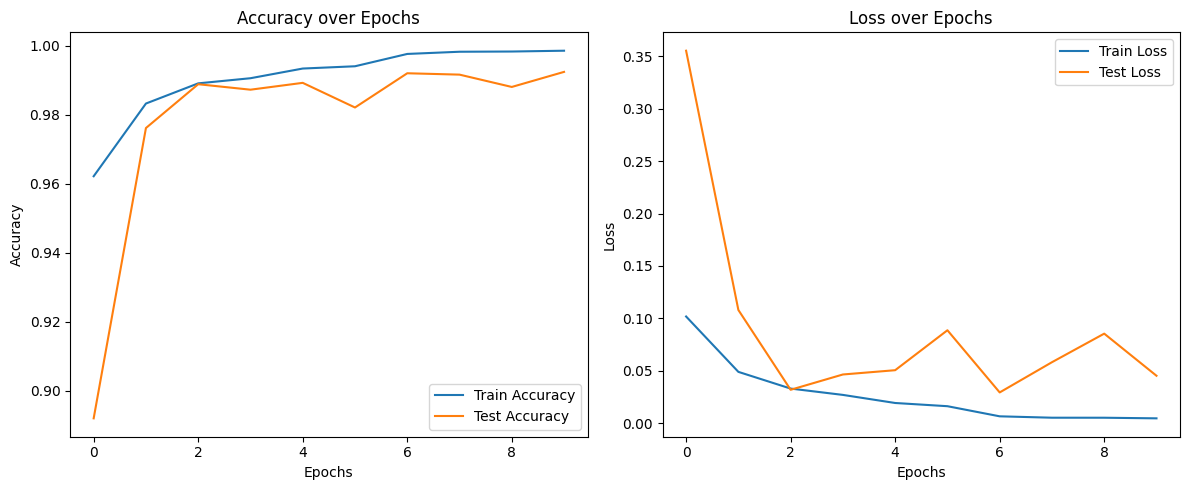

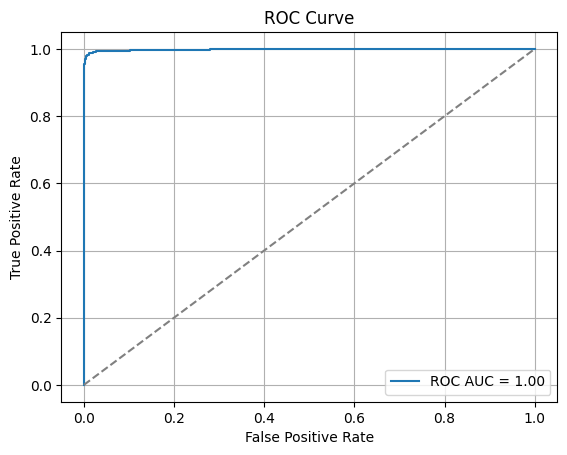

In [5]:
# ========================= 7. LOAD BEST MODEL & EVALUATE =========================
model.load_weights('best_model.keras')

loss, acc = model.evaluate(test_gen)
print(f"\n✅ Final Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

y_true = test_gen.classes
y_pred_prob = model.predict(test_gen).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# ========================= 8. METRICS =========================
print("\n📋 Classification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "TB"]))
print("📌 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print(f"🎯 Precision: {precision_score(y_true, y_pred):.4f}")
print(f"🎯 Recall: {recall_score(y_true, y_pred):.4f}")
print(f"🎯 F1 Score: {f1_score(y_true, y_pred):.4f}")

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ========================= 9. PLOTS =========================
# Accuracy & Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(test_callback.test_accuracies, label='Test Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(test_callback.test_losses, label='Test Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
